# Simulated spectra for signals and noise

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 1

import numpy as np
import scipy.stats
import scipy.fft
import scipy.interpolate
import matplotlib
matplotlib.rcParams['figure.dpi'] = 90

import matplotlib.pyplot as plt

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png','pdf')

# %aimport detectors

# diodes = detectors.diodes
# TIA = detectors.TIA()

rng = np.random.default_rng()

savefig = True
ifig = 1

Samples in signal window = 262144
N(0,1) samples
  RMS = 9.9853e-03
  RMS rel. error = 1.47e-03
  Normal skew p-value = 0.19 (not std. norm. if ~ 0)
  Normal kurtosis p-value = 0.81 (not std. norm. if ~ 0)
IFFT with N(0,1) amp.
  RMS = 1.0008e-02
  RMS rel. error = 8.25e-04
  Normal skew p-value = 0.66 (not std. norm. if ~ 0)
  Normal kurtosis p-value = 0.67 (not std. norm. if ~ 0)
FFT freq. resolution = 0.977 kHz


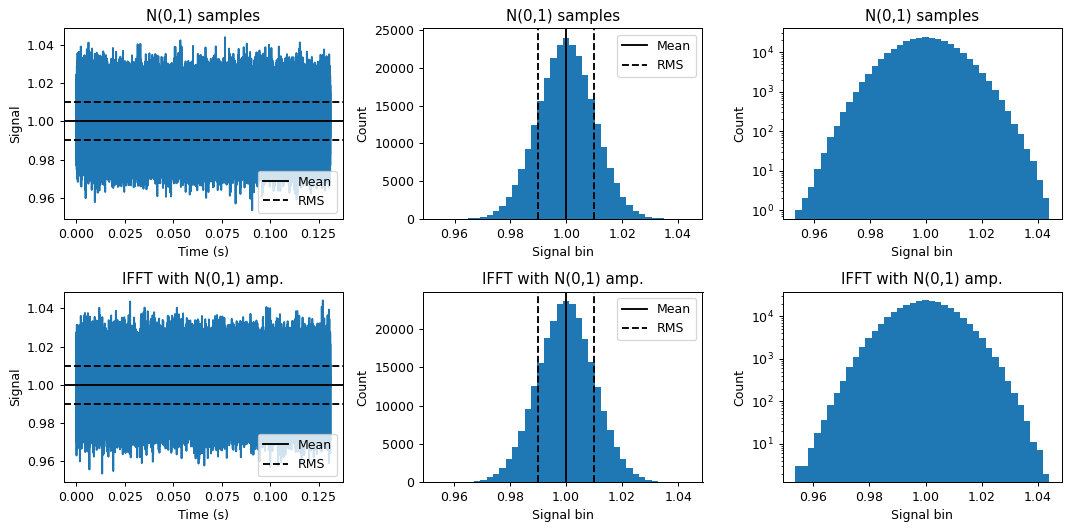

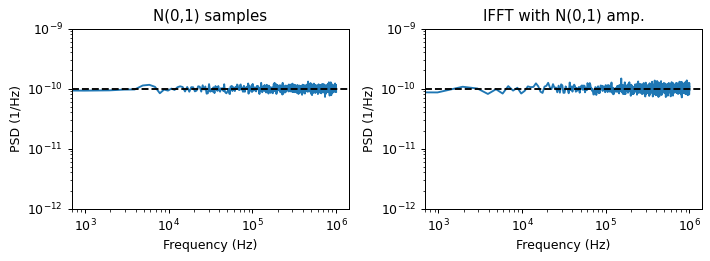

In [10]:
nsamples = 2048 * 128
print(f'Samples in signal window = {nsamples}')

f_sample = 2e6  # sample rate, samples/s (Hz)
bw = f_sample / 2

I_rms = 1e-2

time_array = np.arange(nsamples) / f_sample

freqs_full = scipy.fft.rfftfreq(nfft, 1/f_sample)
nfreqs_full = freqs.size
fres_full = bw / (nfreqs_full-1)


# signal 1: N(0,1) samples and Irms
s1_name = 'N(0,1) samples'
signal_1 = I_rms * rng.standard_normal(nsamples) + 1

# signal 2 from fourier comp and ifft
s2_name = 'IFFT with N(0,1) amp.'
nfreqs = nsamples//2 + 1
amplitudes = I_rms * np.sqrt(nsamples) * rng.standard_normal(nfreqs)
amplitudes[0] = 0
phases = 2*np.pi * rng.random(nfreqs)
fourier_comp = amplitudes * np.exp(1.j * phases)
signal_2 = np.real( scipy.fft.irfft(fourier_comp) ) + 1

ncols, nrows = 3, 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
iax = 0
for signal, name in zip([signal_1, signal_2], [s1_name, s2_name]):
    print(name)
    sig_mean = np.mean(signal)
    rms = np.sqrt(np.mean((signal-sig_mean) ** 2))
    print(f'  RMS = {rms:.4e}')
    print(f'  RMS rel. error = {np.abs(I_rms-rms) / I_rms:.2e}')

    _, skew_pvalue = scipy.stats.skewtest(signal)
    _, kurtosis_pvalue = scipy.stats.kurtosistest(signal)
    print(f'  Normal skew p-value = {skew_pvalue:.2f} (not std. norm. if ~ 0)')
    print(f'  Normal kurtosis p-value = {kurtosis_pvalue:.2f} (not std. norm. if ~ 0)')

    plt.sca(axes.flat[iax])
    plt.plot(time_array, signal)
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.axhline(sig_mean, c='k', ls='-', label='Mean')
    plt.axhline(sig_mean-rms, c='k', ls='--', label='RMS')
    plt.axhline(sig_mean+rms, c='k', ls='--')
    plt.legend()
    iax += 1

    plt.sca(axes.flat[iax])
    plt.hist(signal, bins=40)
    plt.title(name)
    plt.xlabel('Signal bin')
    plt.ylabel('Count')
    plt.axvline(sig_mean, c='k', ls='-', label='Mean')
    plt.axvline(sig_mean-rms, c='k', ls='--', label='RMS')
    plt.axvline(sig_mean+rms, c='k', ls='--')
    plt.legend()
    iax += 1

    plt.sca(axes.flat[iax])
    plt.hist(signal, bins=40, log=True)
    plt.title(name)
    plt.xlabel('Signal bin')
    plt.ylabel('Count')
    iax += 1
plt.tight_layout()


ncols, nrows = 2,1
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
iax = 0

nfft = 2048  # FFT bin size
nbins = nsamples // nfft
f_res = f_sample / nfft  # FFT freq. resolution (Hz)
print(f'FFT freq. resolution = {f_res/1e3:.3f} kHz')

i2 = I_rms ** 2 / bw

# for signal, name in zip([signal_1, signal_2, signal_3], [s1_name, s2_name, s3_name]):
for signal, name in zip([signal_1, signal_2], [s1_name, s2_name]):
    psd2 = np.empty([nfreqs, nbins])
    for i in np.arange(nbins):
        rfft = scipy.fft.rfft( signal[nfft*i:nfft*(i+1)])
        psd2[:,i] = np.abs(rfft) ** 2 / bw / nfft
    mean_psd = np.mean(psd2, axis=1)
    plt.sca(axes.flat[iax])
    plt.loglog(freqs, mean_psd)
    plt.title(name)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (1/Hz)')
    plt.ylim(i2*1e-2,i2*1e1)
    plt.axhline(np.mean(mean_psd), c='k', ls='--')
    plt.axhline(i2, c='k', ls='--')
    iax += 1
plt.tight_layout()

1000.0 1000000.0
1e-06 9.999999999999999e-06
1.3307348686185163e-06 9.999999999999999e-06


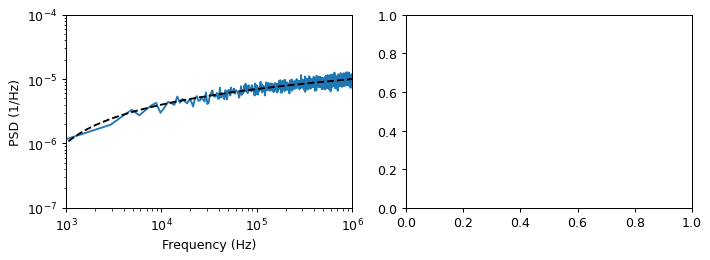

In [33]:
I_rms_noise = 1e-2

# i2_dc = 1e-6
# i2_nyq = 10 * i2_dc

n_fscale = 200
log_fscale = np.geomspace(1e3, bw, n_fscale)
i2_logf = 1 + 9 * np.arange(n_fscale) / (n_fscale-1)
i2_spline = scipy.interpolate.CubicSpline(log_fscale, i2_logf)
i2_linf = np.abs(i2_spline( scipy.fft.rfftfreq(nsamples, 1/f_sample) ))
i2_linf = I_rms_noise * i2_linf / np.sum(i2_linf)
# print(log_fscale[0], log_fscale[-1])
# print(i2_logf[0], i2_logf[-1])
# print(i2_linf[0], i2_linf[-1])

# signal 3 from fourier comp and ifft
s3_name = 'IFFT with N(0,1) amp.'
amplitudes = np.sqrt( i2_linf * bw * nsamples) * rng.standard_normal(nsamples//2+1)
amplitudes[0] = 0
phases = 2*np.pi * rng.random(nsamples//2+1)
fourier_comp = amplitudes * np.exp(1.j * phases)
signal_3 = np.real( scipy.fft.irfft(fourier_comp) ) + 1

ncols, nrows = 2,1
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
iax = 0

# for signal, name in zip([signal_1, signal_2, signal_3], [s1_name, s2_name, s3_name]):
psd2 = np.empty([nfreqs, nbins])
for i in np.arange(nbins):
    sig = signal_3[nfft*i:nfft*(i+1)]
    sig_mean = np.mean(sig)
    rfft = scipy.fft.rfft( sig-sig_mean )
    psd2[:,i] = np.abs(rfft) ** 2 / bw / nfft
mean_psd = np.mean(psd2, axis=1)
plt.sca(axes.flat[iax])
plt.loglog(freqs, mean_psd)
plt.loglog(scipy.fft.rfftfreq(nsamples, 1/f_sample), i2_linf, c='k', ls='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (1/Hz)')
plt.xlim(1e3,bw)
plt.ylim(i2_dc*1e-1,i2_dc*1e2)
iax += 1
plt.tight_layout()